In [1]:
!pip install transformers

     |████████████████████████████████| 2.0MB 13.0MB/s 
     |████████████████████████████████| 870kB 36.0MB/s 
     |████████████████████████████████| 3.3MB 55.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=9992b76608295a6fc83ec43f09059f2433966dce49cee56108e3af735121d3ad
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [2]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [3]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import nltk
from nltk.tokenize import word_tokenize
import torch
from collections import defaultdict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df_te = pd.read_csv('/content/drive/My Drive/revisedATSA.csv')
df_te = df_te.rename(columns={'sentence': 'text', 'aspect': 'aspect_term', 'sentiment': 'Class'})
df_te.head()

,text,aspect_term,Class
0,the bread is top notch as well.,bread,positive
1,i have to say they have one of the fastest del...,delivery times,positive
2,food is always fresh and hot- ready to eat!,food,positive
3,did i mention that the coffee is outstanding?,coffee,positive
4,"certainly not the best sushi in new york, howe...",place,positive


In [7]:
df_te.Class.count()

1120

In [8]:
#df_te = df_te.drop(df_te.index[df_te['Class'] == 'conflict'], inplace = True)
#df_te.Class = df_te.Class.replace('conflict', 'neutral') 
df_test = df_te
df_test.shape
df_test.head(50)

,text,aspect_term,Class
0,the bread is top notch as well.,bread,positive
1,i have to say they have one of the fastest del...,delivery times,positive
2,food is always fresh and hot- ready to eat!,food,positive
3,did i mention that the coffee is outstanding?,coffee,positive
4,"certainly not the best sushi in new york, howe...",place,positive
5,"i trust the people at go sushi, it never disap...",people,positive
6,"straight-forward, no surprises, very decent ja...",japanese food,positive
7,"best spicy tuna roll, great asian salad.",asian salad,positive
8,"best spicy tuna roll, great asian salad.",spicy tuna roll,positive
9,try the rose roll (not on menu).,rose roll,positive


In [9]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
df_test['Class']= label_encoder.fit_transform(df_test['Class']) 
df_test.head()

onehotencoder = preprocessing.OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df_test.Class.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
dfOneHot = pd.DataFrame(X, columns = ["Class_"+str(int(i)) for i in range(df_test.shape[1])]) 
df_test = pd.concat([df_test, dfOneHot], axis=1)
#droping the country column 
df_test= df_test.drop(['Class'], axis=1) 
#printing to verify 
df_test.head()

,text,aspect_term,Class_0,Class_1,Class_2
0,the bread is top notch as well.,bread,0.0,0.0,1.0
1,i have to say they have one of the fastest del...,delivery times,0.0,0.0,1.0
2,food is always fresh and hot- ready to eat!,food,0.0,0.0,1.0
3,did i mention that the coffee is outstanding?,coffee,0.0,0.0,1.0
4,"certainly not the best sushi in new york, howe...",place,0.0,0.0,1.0


In [10]:

df_test.info()
df_test.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text         1120 non-null   object 
 1   aspect_term  1120 non-null   object 
 2   Class_0      1120 non-null   float64
 3   Class_1      1120 non-null   float64
 4   Class_2      1120 non-null   float64
dtypes: float64(3), object(2)
memory usage: 43.9+ KB


,text,aspect_term,Class_0,Class_1,Class_2
0,the bread is top notch as well.,bread,0.0,0.0,1.0
1,i have to say they have one of the fastest del...,delivery times,0.0,0.0,1.0
2,food is always fresh and hot- ready to eat!,food,0.0,0.0,1.0
3,did i mention that the coffee is outstanding?,coffee,0.0,0.0,1.0
4,"certainly not the best sushi in new york, howe...",place,0.0,0.0,1.0
5,"i trust the people at go sushi, it never disap...",people,0.0,0.0,1.0
6,"straight-forward, no surprises, very decent ja...",japanese food,0.0,0.0,1.0
7,"best spicy tuna roll, great asian salad.",asian salad,0.0,0.0,1.0
8,"best spicy tuna roll, great asian salad.",spicy tuna roll,0.0,0.0,1.0
9,try the rose roll (not on menu).,rose roll,0.0,0.0,1.0


In [11]:
df_test.iloc[217]


text           waiters are very friendly and the pasta is out...
aspect_term                                                pasta
Class_0                                                        0
Class_1                                                        0
Class_2                                                        1
Name: 217, dtype: object

In [12]:

df = pd.read_csv('/content/drive/My Drive/data_2_train.csv')
df.head()


,example_id,text,aspect_term,term_location,class
0,3121_0,But the staff was so horrible to us.,staff,8--13,-1
1,2777_0,To be completely fair[comma] the only redeemin...,food,57--61,1
2,1634_0,The food is uniformly exceptional[comma] with ...,food,4--8,1
3,1634_1,The food is uniformly exceptional[comma] with ...,kitchen,55--62,1
4,1634_2,The food is uniformly exceptional[comma] with ...,menu,141--145,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


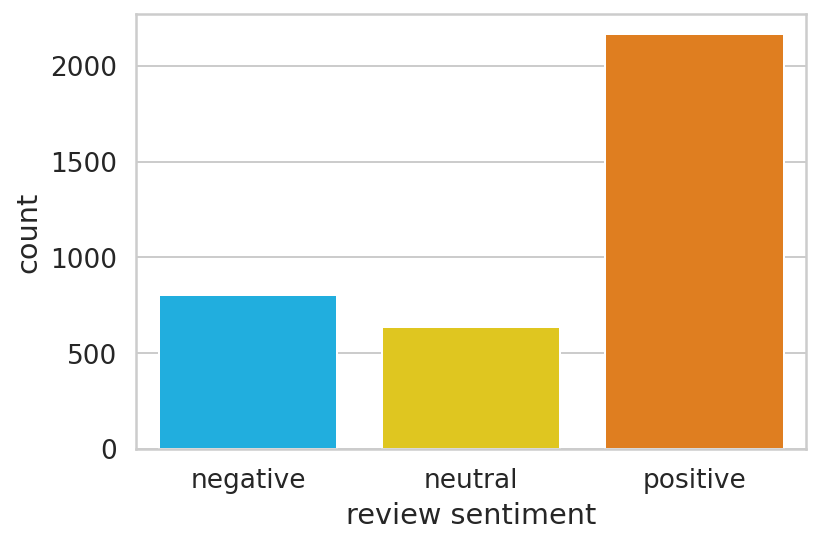

In [13]:

def to_sentiment(rating):
  rating = int(rating)
  if rating == 1:
    return 2
  elif rating == 0:
    return 1
  else:
    return 0
df['sentiment'] = df[' class'].apply(to_sentiment)

#df['sentiment'] = df[' class']
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);


In [14]:
df.info()
df = df.rename(columns={' text': 'text', ' aspect_term': 'aspect_term', ' term_location': 'term_location', ' example_id': 'example_id', ' class': 'class'})
df['text'] = df['text'].apply(lambda x: x.replace('[comma]',',').lower())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   example_id      3602 non-null   object
 1    text           3602 non-null   object
 2    aspect_term    3602 non-null   object
 3    term_location  3602 non-null   object
 4    class          3602 non-null   int64 
 5   sentiment       3602 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 169.0+ KB


,example_id,text,aspect_term,term_location,class,sentiment
0,3121_0,but the staff was so horrible to us.,staff,8--13,-1,0
1,2777_0,"to be completely fair, the only redeeming fact...",food,57--61,1,2
2,1634_0,"the food is uniformly exceptional, with a very...",food,4--8,1,2
3,1634_1,"the food is uniformly exceptional, with a very...",kitchen,55--62,1,2
4,1634_2,"the food is uniformly exceptional, with a very...",menu,141--145,0,1


In [15]:

from sklearn import preprocessing


onehotencoder = preprocessing.OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df.sentiment.values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
df= df.drop(['example_id'], axis=1)
df= df.drop(['class'], axis=1)
df= df.drop(['term_location'], axis=1)
dfOneHot = pd.DataFrame(X, columns = ["Class_"+str(int(i)) for i in range(df.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)
#droping the country column 
df= df.drop(['sentiment'], axis=1) 
#printing to verify 
df.head()


,text,aspect_term,Class_0,Class_1,Class_2
0,but the staff was so horrible to us.,staff,1.0,0.0,0.0
1,"to be completely fair, the only redeeming fact...",food,0.0,0.0,1.0
2,"the food is uniformly exceptional, with a very...",food,0.0,0.0,1.0
3,"the food is uniformly exceptional, with a very...",kitchen,0.0,0.0,1.0
4,"the food is uniformly exceptional, with a very...",menu,0.0,1.0,0.0


In [16]:
df_test['list'] = df_test[df_test.columns[2:]].values.tolist()
new_df_test = df_test[['text', 'aspect_term', 'list']].copy()
new_df_test.head(20)

,text,aspect_term,list
0,the bread is top notch as well.,bread,"[0.0, 0.0, 1.0]"
1,i have to say they have one of the fastest del...,delivery times,"[0.0, 0.0, 1.0]"
2,food is always fresh and hot- ready to eat!,food,"[0.0, 0.0, 1.0]"
3,did i mention that the coffee is outstanding?,coffee,"[0.0, 0.0, 1.0]"
4,"certainly not the best sushi in new york, howe...",place,"[0.0, 0.0, 1.0]"
5,"i trust the people at go sushi, it never disap...",people,"[0.0, 0.0, 1.0]"
6,"straight-forward, no surprises, very decent ja...",japanese food,"[0.0, 0.0, 1.0]"
7,"best spicy tuna roll, great asian salad.",asian salad,"[0.0, 0.0, 1.0]"
8,"best spicy tuna roll, great asian salad.",spicy tuna roll,"[0.0, 0.0, 1.0]"
9,try the rose roll (not on menu).,rose roll,"[0.0, 0.0, 1.0]"


In [17]:
df['list'] = df[df.columns[2:]].values.tolist()
new_df = df[['text', 'aspect_term', 'list']].copy()
new_df.head()

,text,aspect_term,list
0,but the staff was so horrible to us.,staff,"[1.0, 0.0, 0.0]"
1,"to be completely fair, the only redeeming fact...",food,"[0.0, 0.0, 1.0]"
2,"the food is uniformly exceptional, with a very...",food,"[0.0, 0.0, 1.0]"
3,"the food is uniformly exceptional, with a very...",kitchen,"[0.0, 0.0, 1.0]"
4,"the food is uniformly exceptional, with a very...",menu,"[0.0, 1.0, 0.0]"


In [18]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 100
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 4
#epochs = 3
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',return_dict=False)

In [19]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.aspect_term = dataframe.aspect_term
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        aspect_term = str(self.aspect_term[index])
        aspect_term = " ".join(aspect_term.split())
        #print(text)
        inputs = self.tokenizer.encode_plus(
            text,
            aspect_term,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [20]:
# Creating the dataset and dataloader for the neural network

train_size = 1.0
test_size = 1.0
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df_test.sample(frac=test_size,random_state=200)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3602, 6)
TRAIN Dataset: (3602, 3)
TEST Dataset: (1120, 3)


In [21]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                
                }


test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [22]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 3)
    
    def forward(self, ids, mask, token_type_ids):
        _, pooled_output= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(pooled_output)
        output = self.l3(output_2)
        return output

fchidden = 256
hiddendim_lstm = 256
embeddim = 768
numlayers = 12
numclasses = 3
num_heads = 2

class Bert_LSTM(torch.nn.Module):
    def __init__(self, numclasses):
        super(Bert_LSTM, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        self.lstm = torch.nn.LSTM(self.embeddim, self.hiddendim_lstm, bidirectional = False, batch_first=True) # noqa
        self.fc = torch.nn.Linear(self.hiddendim_lstm, self.numclasses)

    def forward(self, ids, mask, token_type_ids):
      last_hidden_state, pooled_output = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
      #print(last_hidden_state.shape)
      #print(pooled_output.shape)
      out, _ = self.lstm(last_hidden_state, None)
      print(out.shape)
      out = self.dropout(out[:, -1, :])
      #print(out.shape)
      out = self.fc(out)
      return out


class Bert_GRU(torch.nn.Module):
    def __init__(self, numclasses):
        super(Bert_GRU, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        self.Gru = torch.nn.GRU(self.embeddim, self.hiddendim_lstm, bidirectional = False, batch_first=True) # noqa
        self.fc = torch.nn.Linear(self.hiddendim_lstm, self.numclasses)

    def forward(self, ids, mask, token_type_ids):
      last_hidden_state, pooled_output = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
      #print(last_hidden_state.shape)
      #print(pooled_output.shape)
      out, _ = self.Gru(last_hidden_state, None)
      #print(out.shape)
      out = self.dropout(out[:, -1, :])
      #print(out.shape)
      out = self.fc(out)
      return out


class Bert_BiLSTM(torch.nn.Module):
    def __init__(self, numclasses):
        super(Bert_BiLSTM, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        self.lstm = torch.nn.LSTM(self.embeddim, self.hiddendim_lstm, bidirectional = True, batch_first=True) # noqa
        self.fc = torch.nn.Linear(self.hiddendim_lstm*2, self.numclasses)

    def forward(self, ids, mask, token_type_ids):
      last_hidden_state, pooled_output = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
      #print(last_hidden_state.shape)
      #print(pooled_output.shape)
      out, _ = self.lstm(last_hidden_state, None)
      #print(out.shape)
      out = self.dropout(out[:, -1, :])
      #print(out.shape)
      out = self.fc(out)
      return out


class Bert_BiGRU(torch.nn.Module):
    def __init__(self, numclasses):
        super(Bert_BiGRU, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        self.Gru = torch.nn.GRU(self.embeddim, self.hiddendim_lstm, bidirectional = True, batch_first=True) # noqa
        self.fc = torch.nn.Linear(self.hiddendim_lstm*2, self.numclasses)

    def forward(self, ids, mask, token_type_ids):
      last_hidden_state, pooled_output = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
      #print(last_hidden_state.shape)
      #print(pooled_output.shape)
      out, _ = self.Gru(last_hidden_state, None)
      #print(out.shape)
      out = self.dropout(out[:, -1, :])
      #print(out.shape)
      out = self.fc(out)
      return out


class Bert_Attention(torch.nn.Module):
    def __init__(self, numclasses):
        super(Bert_Attention, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.fchidden = fchidden
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.embeddim))
        self.q = nn.Parameter(torch.from_numpy(q_t)).float().to(device)
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.embeddim, self.fchidden)) # noqa
        self.w_h = nn.Parameter(torch.from_numpy(w_ht)).float().to(device)

        self.fc = nn.Linear(self.fchidden, self.numclasses)
        #self.softmax = torch.nn.functional.softmax(self.fc, dim=0)
    
    def forward(self, ids, mask, token_type_ids):
      last_hidden_state, pooled_output = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids)
      #print(last_hidden_state.shape)
      #print(pooled_output.shape)
      att = self.attention(last_hidden_state)
      #print("3",att.shape)
      out = self.dropout(att)
      out = self.fc(out)
      
      #print("la",out.shape)
      return out

    def attention(self, h):
        #print("hhhhh",h.shape)
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = torch.nn.functional.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        #print("tem",v_temp.shape)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        #print(v.shape)
        return v

class Bert_BiLAttention(torch.nn.Module):
    def __init__(self, numclasses, device):
        super(Bert_BiLAttention, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.fchidden = fchidden
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        self.lstm = torch.nn.LSTM(self.embeddim, self.hiddendim_lstm, bidirectional = True, batch_first=True)

        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.hiddendim_lstm*2))
        self.q = torch.nn.Parameter(torch.from_numpy(q_t)).float().to(device)
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.hiddendim_lstm*2, self.fchidden)) # noqa
        self.w_h = torch.nn.Parameter(torch.from_numpy(w_ht)).float().to(device)

        self.fc = torch.nn.Linear(self.fchidden, self.numclasses)

    def forward(self, inp_ids, att_mask, token_ids):
        last_hidden_state, pooler_output = self.bert(input_ids=inp_ids, attention_mask=att_mask, token_type_ids=token_ids)
        #print("1",last_hidden_state.shape)
        out, _ = self.lstm(last_hidden_state, None)
        #print("2",out.shape)
        #out = self.attention(out)
        att = self.attention(out)
        #print("3",att.shape)
        out = self.dropout(att)
        out = self.fc(out)
        #print("la",out.shape)
        return out

    def attention(self, h):
        #print("hhhhh",h.shape)
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = torch.nn.functional.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        #print("tem",v_temp.shape)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        #print(v.shape)
        return v


class Bert_BiGAttention(torch.nn.Module):
    def __init__(self, numclasses, device):
        super(Bert_BiGAttention, self).__init__()
        self.numclasses = numclasses
        self.embeddim = embeddim
        self.numlayers = numlayers
        self.hiddendim_lstm = hiddendim_lstm
        self.fchidden = fchidden
        self.dropout = torch.nn.Dropout(0.3)

        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        print("BERT Model Loaded")
        self.Gru = torch.nn.GRU(self.embeddim, self.hiddendim_lstm, bidirectional = True, batch_first=True)

        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.hiddendim_lstm*2))
        self.q = torch.nn.Parameter(torch.from_numpy(q_t)).float().to(device)
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.hiddendim_lstm*2, self.fchidden)) # noqa
        self.w_h = torch.nn.Parameter(torch.from_numpy(w_ht)).float().to(device)

        self.fc = torch.nn.Linear(self.fchidden, self.numclasses)

    def forward(self, inp_ids, att_mask, token_ids):
        last_hidden_state, pooler_output = self.bert(input_ids=inp_ids, attention_mask=att_mask, token_type_ids=token_ids)
        #print("1",last_hidden_state.shape)
        out, _ = self.Gru(last_hidden_state, None)
        #print("2",out.shape)
        #out = self.attention(out)
        att = self.attention(out)
        #print("3",att.shape)
        out = self.dropout(att)
        out = self.fc(out)
        #print("la",out.shape)
        return out

    def attention(self, h):
        #print("hhhhh",h.shape)
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = torch.nn.functional.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        #print("tem",v_temp.shape)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        #print(v.shape)
        return v

#model = Bert_Attention(numclasses)
#model = Bert_BiLAttention(numclasses, device)
#model = Bert_BiGAttention(numclasses, device)
#model = Bert_LSTM(numclasses)
#model = Bert_BiLSTM(numclasses)
model = Bert_GRU(numclasses)
#model = Bert_BiGRU(numclasses)
#model = BERTClass()
model.to(device)
model


BERT Model Loaded


Bert_GRU(
  (dropout): Dropout(p=0.3, inplace=False)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [23]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [24]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [25]:

import copy
#from sklearn.metrics import accuracy

def evaluate(loader, model, device):
    model.eval()
    loss = 0.0
    y_pred = []
    y_true = []
    for _,data in enumerate(loader, 0):
      #print(data)
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)
      with torch.no_grad():
        outputs = model(ids, mask, token_type_ids)
      
      loss = loss_fn(outputs, targets)

      preds = torch.sigmoid(outputs)
      y_pred.extend(preds.tolist())
      y_true.extend(targets.tolist())
      y_predict = np.array(y_pred) >= 0.5

    F1 = round((metrics.accuracy_score(y_true, y_predict)), 2) * 100
    return loss, F1


In [26]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        #print(data)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        print(outputs)
        #print(targets.shape)
        #print(outputs.dtype)
        #print(targets.dtype)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Train Loss:  {loss.item()}')
        
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [27]:
for epoch in range(EPOCHS):
    train(epoch)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Streaming output truncated to the last 5000 lines.
        [-0.0833,  0.5156, -4.0707],
        [-4.9692, -4.0961,  3.8039],
        [-3.7929, -3.8364,  3.2095],
        [-4.5682, -3.8696,  3.1618],
        [-5.0407, -3.9443,  4.3111],
        [ 3.8451, -3.2651, -3.3286],
        [-4.7481, -2.6840,  3.2046],
        [-4.3216, -3.6878,  4.0864],
        [-4.1582, -3.5138,  3.2600],
        [ 2.3232, -1.2765, -4.3384],
        [-3.0450,  2.2386, -2.3249],
        [ 1.5063, -2.3320, -3.4222],
        [-3.8721, -3.2772,  3.9152],
        [-2.0227,  2.8164, -3.3343],
        [-4.4120, -3.7680,  3.6573]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-4.3301, -2.7822,  2.8695],
        [-4.1689, -3.2116,  4.0367],
        [-3.2281, -4.0167,  3.1079],
        [-4.5062, -4.4609,  3.4451],
        [ 2.6986, -3.1189, -3.7141],
        [-4.6033, -3.7907,  3.9534],
        [-0.2561,  0.2482, -3.3194],
        [ 2.8808, -2.8721, -3.6754],
        [-3.5789, -2.2422,  1.3713],
        [ 2.5081, 

In [28]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float) 
            #print(targets.shape)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [29]:
best_accuracy = 0

for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    precision_score_micro = metrics.precision_score(targets, outputs, average='micro')
    precision_score_macro = metrics.precision_score(targets, outputs, average='macro')
    recall_score_micro = metrics.recall_score(targets, outputs, average='micro')
    recall_score_macro = metrics.recall_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    print(f"precision_score (Micro) = {precision_score_micro}")
    print(f"precision_score (Macro) = {precision_score_macro}")
    print(f"recall_score (Micro) = {recall_score_micro}")
    print(f"recall_score (Macro) = {recall_score_macro}")
    if accuracy > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = accuracy

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy Score = 0.8392857142857143
F1 Score (Micro) = 0.8491670418730302
F1 Score (Macro) = 0.7950671912372246
precision_score (Micro) = 0.8564940962761126
precision_score (Macro) = 0.8067248079949612
recall_score (Micro) = 0.8419642857142857
recall_score (Macro) = 0.7897043432757719
Accuracy Score = 0.8392857142857143
F1 Score (Micro) = 0.8491670418730302
F1 Score (Macro) = 0.7950671912372246
precision_score (Micro) = 0.8564940962761126
precision_score (Macro) = 0.8067248079949612
recall_score (Micro) = 0.8419642857142857
recall_score (Macro) = 0.7897043432757719
Accuracy Score = 0.8392857142857143
F1 Score (Micro) = 0.8491670418730302
F1 Score (Macro) = 0.7950671912372246
precision_score (Micro) = 0.8564940962761126
precision_score (Macro) = 0.8067248079949612
recall_score (Micro) = 0.8419642857142857
recall_score (Macro) = 0.7897043432757719
Accuracy Score = 0.8392857142857143
F1 Score (Micro) = 0.8491670418730302
F1 Score (Macro) = 0.7950671912372246
precision_score (Micro) = 0.85

In [30]:
class_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(outputs, targets, target_names=class_names))


              precision    recall  f1-score   support

    Negative       0.73      0.86      0.79       167
     Neutral       0.73      0.63      0.68       229
    Positive       0.90      0.93      0.91       705

   micro avg       0.84      0.86      0.85      1101
   macro avg       0.79      0.81      0.80      1101
weighted avg       0.84      0.86      0.85      1101
 samples avg       0.84      0.84      0.84      1101



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#class_names = ['Class_0', 'Class_1', 'Class_2']

class_names = ['Negative', 'Neutral', 'Positive']
#test_string = "The shells were crisp and authentic, the filling was real ricotta cheese, not the fake junk a lot of Italian Places use these days."
#test_string = "The pizza and garlic bread are good, but the staff members are rude to us."
test_string = "The pizza and pasta are delicious, but the taste of garlic bread is not good."
#at = "staff members"
#at = "garlic bread"
at = "pasta"
#at = "food"
#at = "Italian Places"

inputs = tokenizer.encode_plus(
            test_string,
            at,
            add_special_tokens=True,
            max_length=80,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_tensors='pt',
)

input_ids = inputs['input_ids'].to(device)
mask = inputs['attention_mask'].to(device)
token_type_ids = inputs["token_type_ids"].to(device)
print(input_ids)
print(mask)
print(token_type_ids)

target,  = model(input_ids, mask, token_type_ids)
#output = model(input_ids, attention_mask)

predict = torch.sigmoid(target)
print(predict)

predict = predict.cpu().detach().flatten().numpy()
predictlabel = []

for i, labelname in enumerate(class_names):
  labelprob = predict[i]
  if labelprob > 0.5:
    predictlabel.append(labelname)
predictlabel

print(predictlabel)

tensor([[  101,  1996, 10733,  1998, 24857,  2024, 12090,  1010,  2021,  1996,
          5510,  1997, 20548,  7852,  2003,  2025,  2204,  1012,   102, 24857,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
